In [1]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import (precision_recall_fscore_support,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score,
                             roc_curve)
from sklearn.externals import joblib
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(369)

In [3]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from various_tools import (roc,
                           plot_roc,
                           cross_val_metrics,
                           make_metric_df)

In [4]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [5]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/kurtrm/projects/predicting_equipment_failure/src/static/data/geocoded_address.json'

In [6]:
transformed.head()

,VegMgmt,PMLate,WaterExposure,MultipleConnects,Storm,Age,Latitude,Longitude,Status,Manufacturer_GE,...,Repairs_Rebuild+3,Overloads_100-120%,Overloads_120-150%,Overloads_Above 150%,Overloads_Below 100%,AssetType_1-Phase Pole Transformer,AssetType_3-Phase Transformer,AssetType_DF-series Transformer,AssetType_Padmount Transformer,AssetType_Voltage Transformer
0,1,0,0,1,0,70.3,33.516805,-84.258478,1,0,...,1,0,0,0,1,1,0,0,0,0
1,1,0,0,0,0,70.3,33.959887,-84.435503,1,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,70.3,33.932735,-84.259163,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,0,70.3,33.555964,-84.257573,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,0,0,0,0,70.3,33.478919,-84.354102,0,0,...,0,0,0,1,0,1,0,0,0,0


In [7]:
# For later use
lat_longs_status = transformed[['Latitude', 'Longitude', 'Status']]

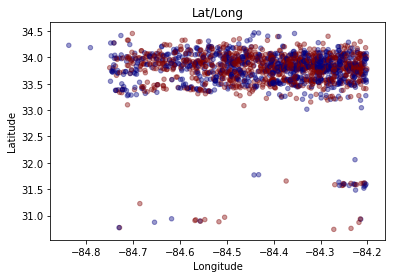

In [8]:
lat_longs_status.plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

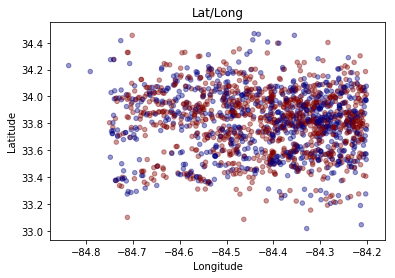

In [9]:
lat_longs_status[lat_longs_status['Latitude'] > 33].plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

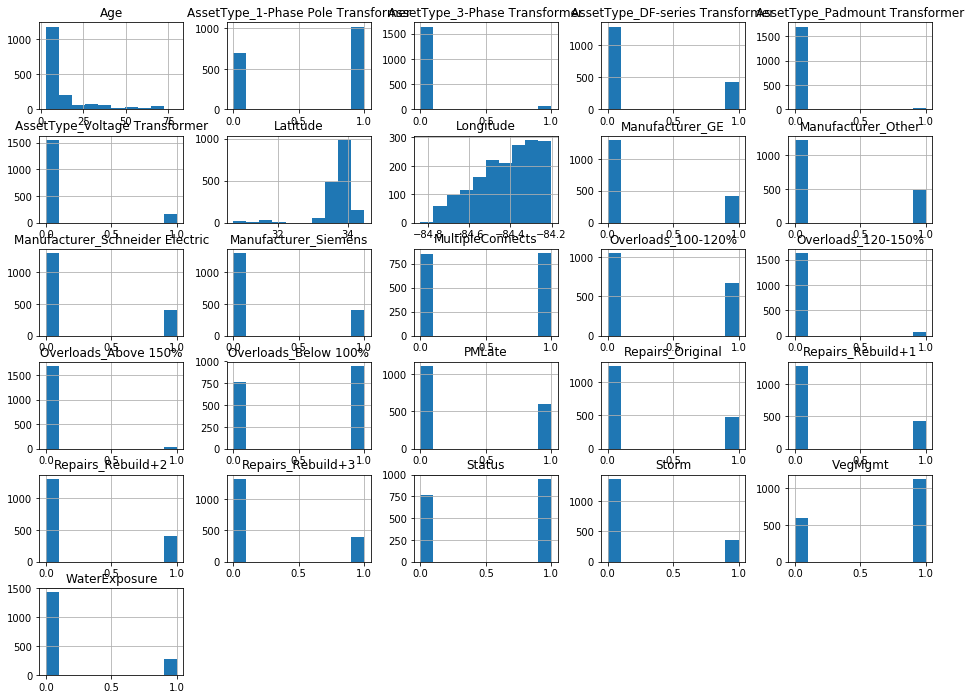

In [10]:
transformed.hist(figsize=(16, 12));

In [11]:
train, test = train_test_split(transformed.drop(['Latitude', 'Longitude'], axis=1), test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                                                    train['Status'].values, test_size=.2)

In [12]:
log_reg = LogisticRegression()
rfc = RandomForestClassifier(50)
gbc = GradientBoostingClassifier(learning_rate=.005, subsample=.5, n_estimators=250)
log_reg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [13]:
metrics = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
make_metric_df([log_reg, rfc, gbc], X_test, y_test, metrics)

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier
average_precision,1.000000,1.000000,1.000000
f1,1.000000,1.000000,1.000000
neg_log_loss,-0.152684,-0.042199,-0.041925
recall,1.000000,1.000000,1.000000
roc_auc,1.000000,1.000000,1.000000


In [14]:
X_train.shape, X_test.shape

((1097, 23), (275, 23))

In [15]:
rfc.feature_importances_.shape

(23,)

In [16]:
rfc_features = pd.DataFrame(rfc.feature_importances_,
                        index=train.drop('Status', axis=1).columns,
                        columns=['Importance'])

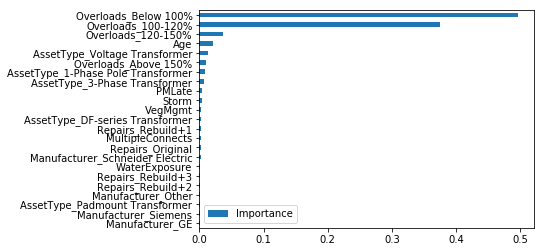

In [17]:
rfc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [18]:
gbc_features = pd.DataFrame(gbc.feature_importances_,
                            index=train.drop('Status', axis=1).columns,
                            columns=['Importance'])

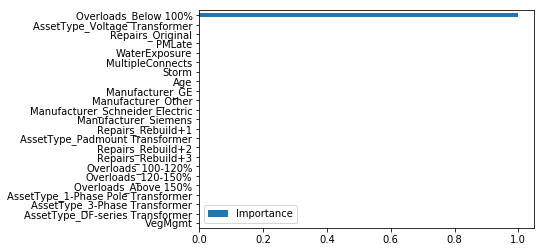

In [19]:
gbc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [20]:
logreg_features = pd.DataFrame(log_reg.coef_.flatten(),
                               index=train.drop('Status', axis=1).columns,
                               columns=['Importance'])

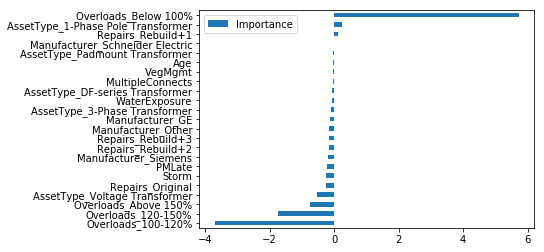

In [21]:
logreg_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [22]:
transformed[['Overloads_Below 100%', 'Status']].sum()

Overloads_Below 100%    950
Status                  950
dtype: int64

### Data Leakage in "Overloads_Below 100%"
So...if a transformer has ever been overloaded, it is a "problem transformer."
From [this](https://www.hammondpowersolutions.com/faq/what-is-the-effect-of-overload/) website:
> _Overload is when a transformer is subjected to voltages and/or currents that exceed its design specifications. During overloading conditions, excess heat will cause the insulation system to break down, resulting in decreased life expectancy of the transformer._

This column correlates perfectly with Y, so if we wanted to determine which transformers to service beyond this one, we'll have to remake the models on all other columns.

But there may still be data leakage in the other 'overload' columns, so I should probably drop those as well.

In [23]:
train, test = train_test_split(transformed.drop(['Latitude', 'Longitude', 'Overloads_Below 100%',
                                                 'Overloads_100-120%', 'Overloads_120-150%', 'Overloads_Above 150%'], axis=1), test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                                                    train['Status'].values, test_size=.2)

In [24]:
log_reg = LogisticRegression()
rfc = RandomForestClassifier(50)
gbc = GradientBoostingClassifier(learning_rate=.005, subsample=.5, n_estimators=250)
log_reg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [25]:
metrics = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
make_metric_df([log_reg, rfc, gbc], X_test, y_test, metrics)

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier
average_precision,0.730412,0.621948,0.703011
f1,0.683476,0.621446,0.686076
neg_log_loss,-0.643336,-0.675456,-0.628657
recall,0.755665,0.635222,0.650246
roc_auc,0.686973,0.631152,0.676365


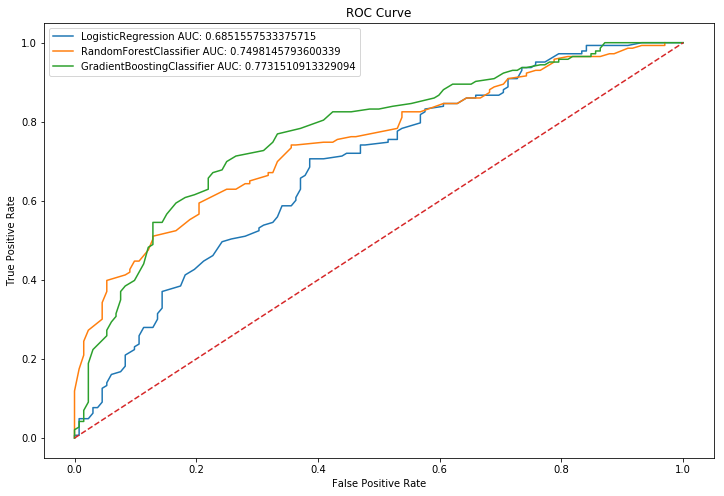

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for model in [log_reg, rfc, gbc]:
    plot_roc(model, X_test, y_test, ax)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    legend_data = '{} AUC: {}'.format(model.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

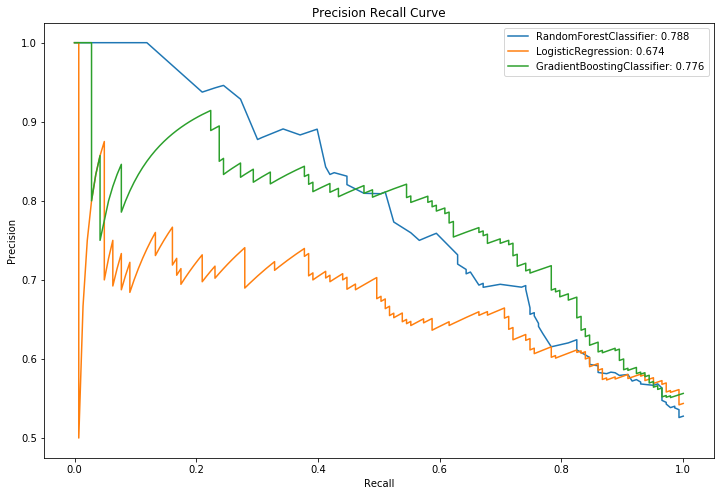

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
for mod in [rfc, log_reg, gbc]:
    precision, recall, threshold = precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1])
    avg_prec = average_precision_score(y_test, mod.predict_proba(X_test)[:, 1])
    ax.plot(recall, precision, label=f'{mod.__class__.__name__}: {avg_prec:.3f}')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('Precision Recall Curve')
ax.legend();

In [28]:
rfc_features = pd.DataFrame(rfc.feature_importances_,
                        index=train.drop('Status', axis=1).columns,
                        columns=['Importance'])

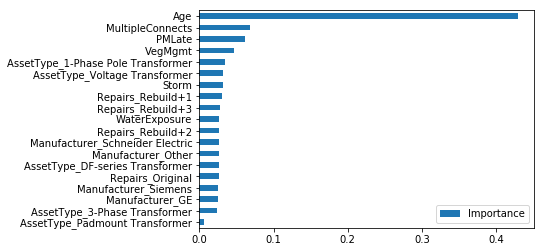

In [29]:
rfc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [30]:
gbc_features = pd.DataFrame(gbc.feature_importances_,
                            index=train.drop('Status', axis=1).columns,
                            columns=['Importance'])

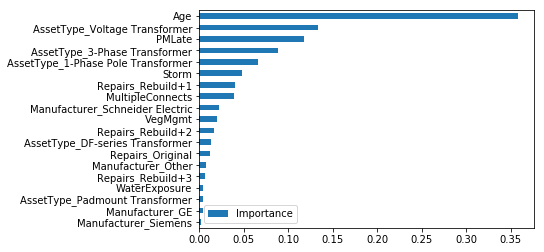

In [31]:
gbc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [32]:
logreg_features = pd.DataFrame(log_reg.coef_.flatten(),
                               index=train.drop('Status', axis=1).columns,
                               columns=['Importance'])

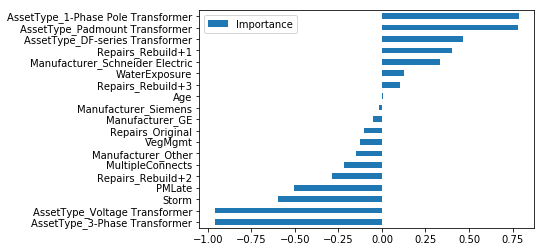

In [33]:
logreg_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

### Initial Assessment
Age is a continuous feature, so it shows up much stronger in the forest models. Made some shitty models, next I'll do some cross validation.

In [34]:
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [1.0, 10.0, 100.0, 1000.0]}
sgd_params = {'loss': ['log'],
              'penalty': ['elasticnet'],
              'alpha': [.0001, .0005, .001, .005],
              'l1_ratio': [.15, .3, .45, .6, .75],
              'n_jobs': [-1]}
rfc_params = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'oob_score': [False, True],
              'n_jobs': [-1]}
ext_params_1 = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'bootstrap': [False],
              'oob_score': [False],
              'n_jobs': [-1]}
ext_params_2 = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'bootstrap': [True],
              'oob_score': [True],
              'n_jobs': [-1]}
gbc_params = {'n_estimators': [500],
              'learning_rate': [.005, .0001, .0005, .00001],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 5],
              'max_features': ['sqrt', 'log2']}

In [35]:
def grid_search_models(models: list, param_dicts: list, X: np.ndarray, y: np.ndarray) -> list:
    """
    Return a list of grid search objects.
    models should contain a list of model class references.
    models and param_dicts will be zipped, so ensure they
    are ordered with each other.
    """
    grid_searched_models = []
    for model, params in zip(models, param_dicts):
        search = GridSearchCV(model(),
                              params, cv=10, refit=True, verbose=True)
        search.fit(X_train, y_train)
        grid_searched_models.append(search)
    
    return grid_searched_models

In [36]:
# model_reflist = [LogisticRegression,
#                  SGDClassifier,
#                  RandomForestClassifier,
#                  ExtraTreesClassifier,
#                  ExtraTreesClassifier,
#                  GradientBoostingClassifier]
# params_list = [logreg_params, sgd_params, rfc_params, ext_params_1, ext_params_2, gbc_params]
# scores = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
# models = grid_search_models(model_reflist, params_list, X_train, y_train)

In [37]:
# joblib.dump(models, 'model_list.pkl')

In [38]:
model_list = joblib.load('model_list.pkl')

In [39]:
besties = [clone(mod.best_estimator_) for mod in model_list]

In [40]:
make_metric_df(besties, X_train, y_train, metrics)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaco

,ExtraTreesClassifier,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier,SGDClassifier
average_precision,0.722092,0.829629,0.717767,0.791269,0.714286
f1,0.695723,0.741853,0.720403,0.724628,0.637983
neg_log_loss,-0.652198,-0.564947,-0.638132,-0.591214,-1.205053
recall,0.715447,0.814634,0.816260,0.757724,0.707317
roc_auc,0.683900,0.780527,0.681675,0.745846,0.644586


### Model Assessment

I don't know a whole lot about ExtraTreesClassifier, but my broad understanding is that it increases the randomness of the trees by randomizing the threshold at each split. A learning opportunity.

GradientBoosting outperforms the other models on all metrics. Still, random forest is a close second, and it may be worth investing some time to improve a logistic regression model.

I've heard of elastic net regression which combines l1 and l2 regularization, so I wanted to see if I could use it in the logistic regression model. The way to do this was to use sklearn's SGDClassifier and change the loss to 'log' and metric to 'elasticnet.' This seems to perform worse than l2 regularization at all tested points of l1_ratio.

Lastly, there seemed to be some consensus that if your data is somewhat sparse, it's worth observing a log reg's performance with l1 regularization (since this data is somewhat sparse). l2 still proved to be a better choice.

In [41]:
make_metric_df([besties[3]], X_train, y_train, metrics)

,ExtraTreesClassifier
average_precision,0.723785
f1,0.680051
neg_log_loss,-0.709323
recall,0.694309
roc_auc,0.677266


/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


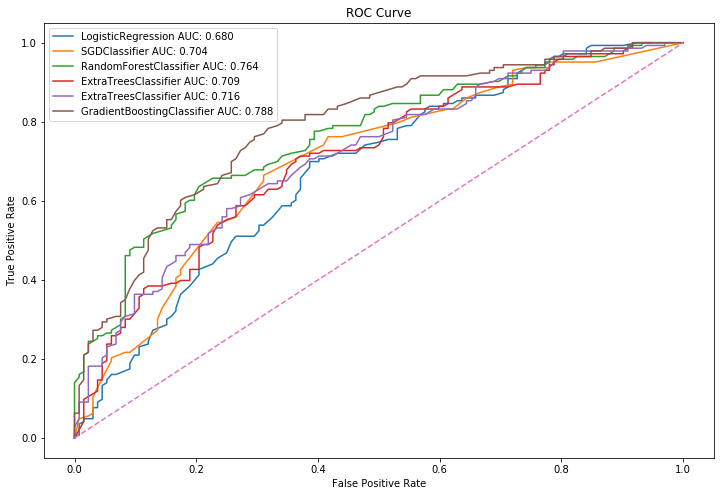

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for a_model in besties:
    a_model.fit(X_train, y_train)
    plot_roc(a_model, X_test, y_test, ax)
    auc_score = roc_auc_score(y_test, a_model.predict_proba(X_test)[:, 1])
    legend_data = '{} AUC: {:.3f}'.format(a_model.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

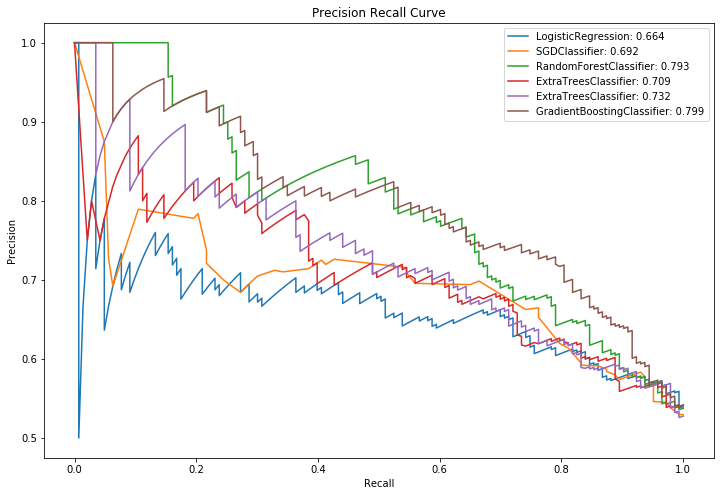

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
for a_mod in besties:
    precision, recall, threshold = precision_recall_curve(y_test, a_mod.predict_proba(X_test)[:, 1])
    avg_prec = average_precision_score(y_test, a_mod.predict_proba(X_test)[:, 1])
    ax.plot(recall, precision, label=f'{a_mod.__class__.__name__}: {avg_prec:.3f}')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('Precision Recall Curve')
ax.legend();

I'll work on some fine tuning of the random forest and gradient boosting classifier. In the meantime, I'm curious to see if a KNN model can make any decent prediction on lat/longs.

In [44]:
ll_X_train, ll_X_test, ll_y_train, ll_y_test = train_test_split(lat_longs_status.drop('Status', axis=1).values, lat_longs_status['Status'].values, test_size=.2)

In [45]:
knn = KNeighborsClassifier()
knn.fit(ll_X_train, ll_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [46]:
make_metric_df([KNeighborsClassifier(n_neighbors=3)], ll_X_train, ll_y_train, metrics)

,KNeighborsClassifier
average_precision,0.588999
f1,0.597706
neg_log_loss,-4.775274
recall,0.611425
roc_auc,0.540854


In [47]:
initial = make_metric_df([KNeighborsClassifier(n_neighbors=3)], ll_X_train, ll_y_train, metrics)
for i in range(4, 31):
    metric_df = make_metric_df([KNeighborsClassifier(n_neighbors=i)], ll_X_train, ll_y_train, metrics)
    metric_df.columns = ['KNeighborsClassifier' + f'_{i}']
    initial = pd.concat([initial, metric_df], axis=1)

In [48]:
initial.idxmax(axis=1)

average_precision       KNeighborsClassifier
f1                   KNeighborsClassifier_27
neg_log_loss         KNeighborsClassifier_30
recall               KNeighborsClassifier_29
roc_auc                 KNeighborsClassifier
dtype: object

In [49]:
initial[['KNeighborsClassifier', 'KNeighborsClassifier_29']]

,KNeighborsClassifier,KNeighborsClassifier_29
average_precision,0.588999,0.567228
f1,0.597706,0.643500
neg_log_loss,-4.775274,-0.704523
recall,0.611425,0.765190
roc_auc,0.540854,0.485560


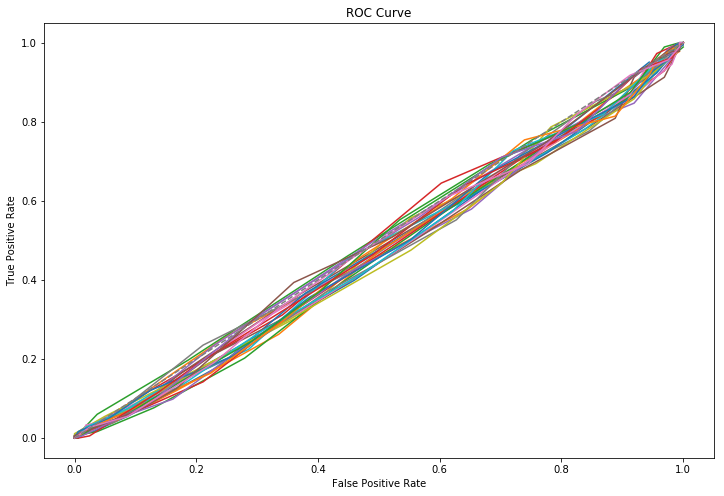

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
scaled_X_train = StandardScaler().fit_transform(ll_X_train)
scaled_X_test = StandardScaler().fit_transform(ll_X_test)
for i in range(4, 31):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(scaled_X_train, ll_y_train)
    roc_plot = plot_roc(knn, scaled_X_test, ll_y_test, ax)
    auc_score = roc_auc_score(ll_y_test, knn.predict_proba(scaled_X_test)[:, 1].reshape(-1, 1))
    legend_data = '{} AUC: {:.3f}'.format(knn.__class__.__name__ + f'_{i}', auc_score)
    legend.append(legend_data)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

Nice...

## Tertiary Modeling

Even though it doesn't make any sense in context to the rest of the data, I'd like to see if distance from ocean has any predictive power. I'm going to remake the pipeline and train test splits for this assessment.

In [51]:
ocean_pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                               'MilesFromOcean',
                                               'Repairs',
                                               'Overloads',
                                               'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'AssetZip']))
ocean_transformed = pipe.fit_transform(df)

In [52]:
o_train, o_test = train_test_split(ocean_transformed.drop(['Latitude', 'Longitude', 'Overloads_Below 100%',
                                                 'Overloads_100-120%', 'Overloads_120-150%', 'Overloads_Above 150%'], axis=1), test_size=.2)
o_X_train, o_X_test, o_y_train, o_y_test = train_test_split(o_train.drop('Status', axis=1).values,
                                                    o_train['Status'].values, test_size=.2)

In [53]:
# model_reflist = [LogisticRegression,
#                  SGDClassifier,
#                  RandomForestClassifier,
#                  ExtraTreesClassifier,
#                  ExtraTreesClassifier,
#                  GradientBoostingClassifier]
# params_list = [logreg_params, sgd_params, rfc_params, ext_params_1, ext_params_2, gbc_params]
# scores = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
# models = grid_search_models(model_reflist, params_list, o_X_train, o_y_train)

In [54]:
# o_besties = [clone(mod.best_estimator_) for mod in models]

In [55]:
# make_metric_df(o_besties, o_X_train, o_y_train, metrics)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


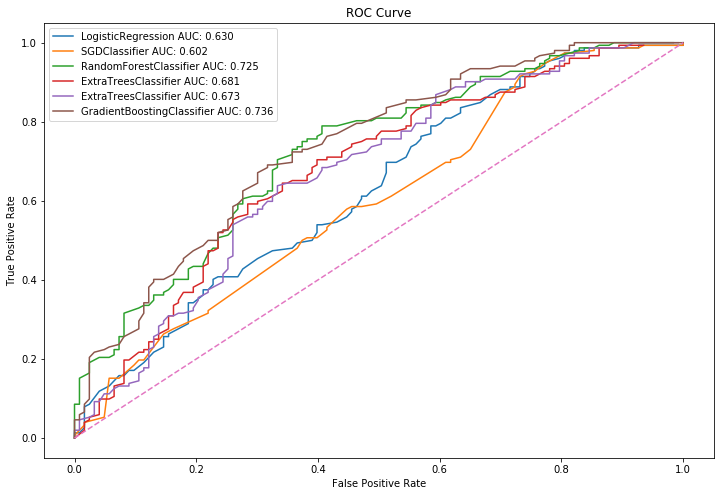

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for a_model in besties:
    a_model.fit(o_X_train, o_y_train)
    plot_roc(a_model, o_X_test, o_y_test, ax)
    auc_score = roc_auc_score(o_y_test, a_model.predict_proba(o_X_test)[:, 1])
    legend_data = '{} AUC: {:.3f}'.format(a_model.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

Not much of an increase in performance here. 

## Average Repair Cost (?)

This next section explores whether average repair cost can be used in the analysis.

In [57]:
age_pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AvgRepairCost', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'AssetZip']))
age_transformed = age_pipe.fit_transform(df)

In [58]:
age_transformed.columns

Index(['VegMgmt', 'PMLate', 'WaterExposure', 'MultipleConnects', 'Storm',
       'AvgRepairCost', 'Age', 'Latitude', 'Longitude', 'Status',
       'Manufacturer_GE', 'Manufacturer_Other',
       'Manufacturer_Schneider Electric', 'Manufacturer_Siemens',
       'Repairs_Original', 'Repairs_Rebuild+1', 'Repairs_Rebuild+2',
       'Repairs_Rebuild+3', 'Overloads_100-120%', 'Overloads_120-150%',
       'Overloads_Above 150%', 'Overloads_Below 100%',
       'AssetType_1-Phase Pole Transformer', 'AssetType_3-Phase Transformer',
       'AssetType_DF-series Transformer', 'AssetType_Padmount Transformer',
       'AssetType_Voltage Transformer'],
      dtype='object')

In [59]:
age_transformed['AvgRepairCost'][age_transformed['Overloads_Below 100%'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Overloads_Above 150%'] == 1].mean()

75390.16013684183

79478.53166666669

In [60]:
age_transformed['AvgRepairCost'][(age_transformed[['Overloads_Above 150%', 'Overloads_100-120%', 'Overloads_120-150%']] == 1).any(axis=1)].mean()
age_transformed['AvgRepairCost'][age_transformed['Overloads_Below 100%'] == 1].mean()

74107.09916449085

75390.16013684183

In [61]:
age_transformed['AvgRepairCost'][age_transformed['Repairs_Original'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Repairs_Rebuild+1'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Repairs_Rebuild+2'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Repairs_Rebuild+3'] == 1].mean()

76128.61375000009

74411.21228110604

73217.43739024404

75350.9223500001

In [62]:
age_transformed['AvgRepairCost'][age_transformed['Manufacturer_GE'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Manufacturer_Other'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Manufacturer_Schneider Electric'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Manufacturer_Siemens'] == 1].mean()

75395.9274698796

74927.48910788381

75122.12458333348

73801.71194647212

In [63]:
age_transformed['AvgRepairCost'][age_transformed['Status'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['Status'] == 0].mean()

75390.16013684183

74107.09916449085

In [64]:
age_transformed['AvgRepairCost'][age_transformed['WaterExposure'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['WaterExposure'] == 0].mean()

74034.26866906484

74968.82016689803

In [65]:
age_transformed['AvgRepairCost'][age_transformed['MultipleConnects'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['MultipleConnects'] == 0].mean()

74452.62123986086

75186.4923329425

In [66]:
age_transformed['AvgRepairCost'][age_transformed['PMLate'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['PMLate'] == 0].mean()

75574.66059504157

74405.05889288904

In [67]:
age_transformed['AvgRepairCost'][age_transformed['VegMgmt'] == 1].mean()
age_transformed['AvgRepairCost'][age_transformed['VegMgmt'] == 0].mean()

74027.68815111082

76320.71221658225

### Repair Cost Analysis
There is no signicant difference in average repair costs across any of the features. Additionally, these numbers seem very high. Any profit/cost analysis will be estimated from here on out.

## Building a Final Model

I'll stick to Gradient Boosting and Random Forests and add some additional parameters to my grid search.

In [68]:
# num_trees = []
# oob_score = []
# for i in range(10, 200):
#     rfc_n = RandomForestClassifier(n_estimators=i,
#                                    criterion='entropy',
#                                    min_samples_leaf=5,
#                                    oob_score=True,
#                                    n_jobs=-1,
#                                    max_features='sqrt',
#                                    random_state=369)
#     rfc_n.fit(X_train, y_train)
#     num_trees.append(i)
#     oob_score.append(1 - rfc_n.oob_score_)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=22, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=28, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=33, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=34, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=37, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=38, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=42, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=43, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=44, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=47, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=48, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=49, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=52, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=53, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=54, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=57, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=58, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=59, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=62, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=63, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=66, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=67, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=68, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=72, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=73, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=74, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=76, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=78, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=79, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=82, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=83, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=84, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=85, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=86, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=87, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=88, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=91, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=92, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=93, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=94, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=98, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=99, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=101, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=102, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=103, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=104, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=105, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=106, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=107, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=108, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=109, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=111, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=112, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=113, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=114, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=116, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=117, n_jobs=-1,
            oob_score=True, random_state=369, verbose=0, warm_start=False)

KeyboardInterrupt: 

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(num_trees, oob_score)
# ax.set_xlabel('# trees')
# ax.set_ylabel('OOB Score')
# ax.set_title('OOB Score Evaluation')

In [ ]:
# opt_num_trees = num_trees[oob_score.index(min(oob_score))]

In [69]:
ref_rfc_params = {'n_estimators': [59],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'n_jobs': [-1]}
ref_gbc_params = {'n_estimators': [1000],
              'learning_rate': [.005, .0001, .0005, .00001],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 5],
              'subsample': [1.0, .75, .5, .25, .1],
              'max_features': ['sqrt', 'log2']}

In [70]:
# ref_model_reflist = [RandomForestClassifier,
#                  GradientBoostingClassifier]
# new_params_list = [ref_rfc_params, ref_gbc_params]
# scores = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
# models = grid_search_models(ref_model_reflist, new_params_list, X_train, y_train)

In [71]:
# new_besties = [clone(grid.best_estimator_) for grid in models]

In [72]:
# joblib.dump(new_besties, 'refined_models.pkl')

In [73]:
new_besties = joblib.load('refined_models.pkl')

In [74]:
new_besties

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=59, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.005, loss='deviance', max_depth=5,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=1000,
               presort='auto', random_state=None, subsample=0.5, verbose=0,
               warm_start=False)]

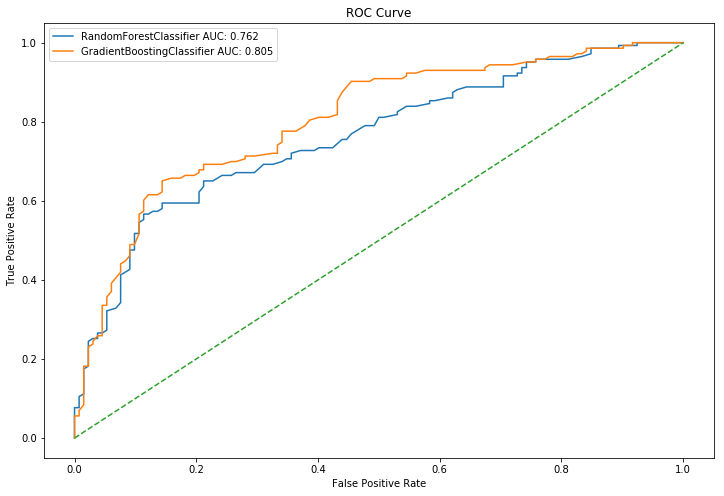

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for mod in new_besties:
    mod.fit(X_train, y_train)
    plot_roc(mod, X_test, y_test, ax)
    auc_score = roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])
    legend_data = '{} AUC: {:.3f}'.format(mod.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

In [76]:
unseen_X, unseen_y = test.drop('Status', axis=1).values, test['Status'].values

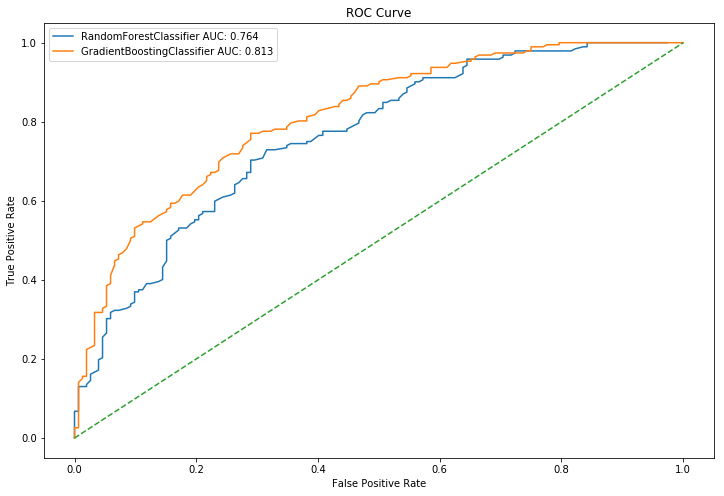

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for mod in new_besties:
    mod.fit(X_train, y_train)
    plot_roc(mod, unseen_X, unseen_y, ax)
    auc_score = roc_auc_score(unseen_y, mod.predict_proba(unseen_X)[:, 1])
    legend_data = '{} AUC: {:.3f}'.format(mod.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

In [78]:
#transformed[['Latitude', 'Longitude']].to_json('../src/static/data/lat_long.json')

In [79]:
figged = ax.get_figure()
figged.savefig('/mnt/c/Users/kurtrm/Documents/final_roc.png')

In [85]:
probs = new_besties[1].predict_proba(unseen_X)
fpr, tpr, thresholds = roc_curve(unseen_y, probs[:, 1])

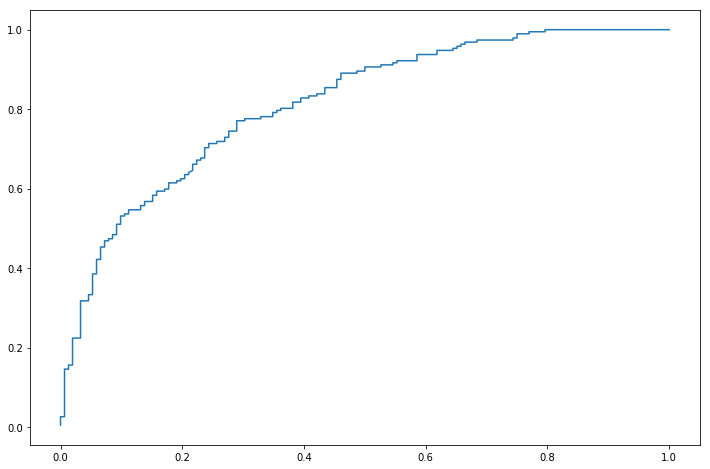

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(fpr, tpr)

The sklearn `roc_curve` implementation looks a bit better than my scratch version.